In [212]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from keras.models import Model
from keras.layers import Input, Dense
from keras.optimizers import Adam

from sklearn.metrics import mean_squared_error

In [213]:
train = pd.read_csv("Datasets/DailyDelhiClimateTrain.csv")
test  = pd.read_csv("Datasets/DailyDelhiClimateTest.csv")

# Drop dates
train_values = train.drop(columns=["date"]).values
test_values  = test.drop(columns=["date"]).values

# Index of humidity in the dropped-data arrays
humidity_idx = train.drop(columns=["date"]).columns.get_loc("humidity")

In [214]:
T = 7   # memory window

def make_dataset(values, T, humidity_idx):
    X = []
    Y = []
    for t in range(len(values) - T):
        X.append(values[t:t+T])                 # (T, 4)
        Y.append(values[t+T][humidity_idx])     # scalar target
    return np.array(X), np.array(Y)

# Training windows
X_train, Y_train = make_dataset(train_values, T, humidity_idx)

print("Train shapes:", X_train.shape, Y_train.shape)

Train shapes: (1455, 7, 4) (1455,)


In [215]:
N, _, D = X_train.shape   # D = number of features (4)
X_train_flat = X_train.reshape(N, T*D)

i = Input(shape=(T*D,))
x = Dense(1)(i)
model = Model(i, x)

model.compile(
    loss="mse",
    optimizer=Adam(learning_rate=0.01)
)


r = model.fit(
    X_train_flat[:-N//2], Y_train[:-N//2],
    epochs=80,
    validation_data=(X_train_flat[-N//2:], Y_train[-N//2:])
)

Epoch 1/80
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 208026.4375 - val_loss: 65339.1172
Epoch 2/80
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 17431.7852 - val_loss: 25550.5762
Epoch 3/80
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3037.1504 - val_loss: 19636.4473
Epoch 4/80
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1525.4972 - val_loss: 19386.1855
Epoch 5/80
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1365.7109 - val_loss: 19283.6367
Epoch 6/80
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1300.2157 - val_loss: 19219.9805
Epoch 7/80
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1222.4536 - val_loss: 19089.6035
Epoch 8/80
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1166.5580 - val_loss: 19053.5488
Epoch 9/80
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1090.3094 - val_loss: 18999.0840
Epoch 10/80
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1031.1305 - val_loss: 18868.5039
Epoch 11/80
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 958.7441 - val_loss: 18807.

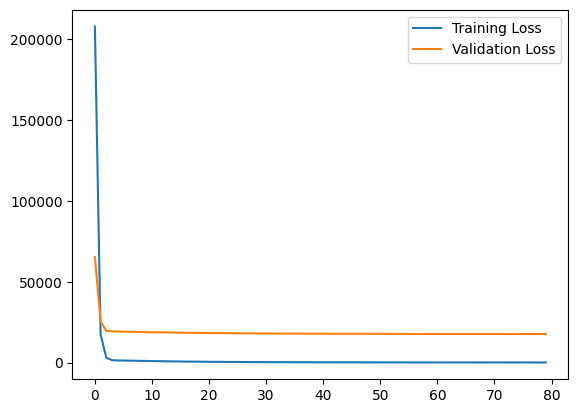

In [216]:
plt.plot(r.history["loss"], label="Training Loss")
plt.plot(r.history["val_loss"], label="Validation Loss")
plt.legend()

In [217]:
test_targets = test_values[:, humidity_idx]  # real humidity in test
test_preds   = []

# The first window for prediction must come from the END of the train set
last_window = train_values[-T:].copy()   # shape (T, 4)

for _ in range(len(test_targets)):
    # Flatten for model input
    inp = last_window.reshape(1, T*D)
    p = model.predict(inp, verbose=0)[0, 0]

    test_preds.append(p)

    # Shift + insert predicted humidity while preserving other test values
    new_row = last_window[-1].copy()

    # Replace only humidity with prediction
    new_row[humidity_idx] = p

    # Roll window
    last_window = np.vstack([last_window[1:], new_row])

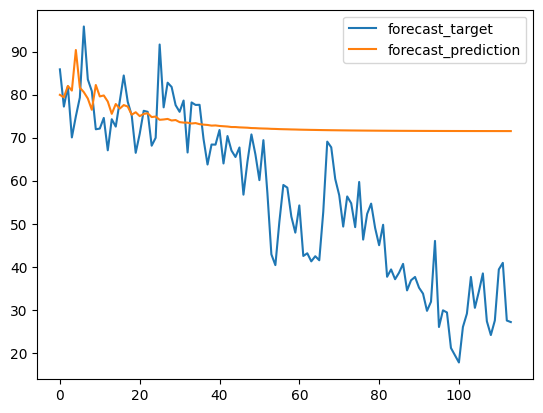

In [218]:
plt.plot(test_targets, label="forecast_target")
plt.plot(test_preds, label="forecast_prediction")
plt.legend()

In [219]:
# Accuracy metrics
mse = mean_squared_error(test_targets, test_preds)

print("Test MSE:", mse)

Test MSE: 592.0596284320353
